# About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy
from time import time
pandas.options.display.max_columns = 999

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score

## Get data

In [64]:
!cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root
!cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root
import root_numpy
#data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_100000.root'))
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_train_100000.root' already there; not retrieving.
wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_train_100000.root' already there; not retrieving.
wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_test.root' already there; not retrieving.


### Read the smallest part of the data file

In [65]:
print data.shape
data.head()


(10000, 30)


,event_id,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,jet2_pt,jet2_eta,jet2_phi,jet2_btag,jet3_pt,jet3_eta,jet3_phi,jet3_btag,jet4_pt,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1000001,1,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,2.000023,57.689522,-0.161628,-0.682047,0.000000,71.954201,1.154233,-2.858513,2.000016,79.948036,0.877472,-0.256736,0.000000,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.685760
1,1000002,1,54.250927,-1.057915,2.310697,51.167873,2.545749,31.039040,-2.220276,-0.737298,0.000000,52.221519,-1.094289,-0.252777,2.000023,42.725616,1.474829,2.906143,0.000000,71.681404,-1.139118,-1.300325,2.000016,65.837746,201.096756,83.321556,208.039688,67.118484,287.363983,527.247559
2,1000003,1,47.746025,-0.783184,2.660325,68.165527,-1.700790,36.945312,-1.151738,-0.626912,0.000000,118.880913,-0.211263,1.326902,0.000000,40.954044,-1.149437,2.123149,1.000011,113.246666,-0.798898,-1.605550,2.000016,69.316925,156.334732,95.307602,149.089005,130.389206,237.879318,336.058838
3,1000004,0,45.950066,1.613817,0.964722,39.302082,-0.075989,84.307426,0.465748,2.287783,2.000016,46.788040,0.441073,-1.303352,0.000000,15.260404,2.409047,-0.850500,0.000000,30.741282,-0.586711,-2.256246,2.000023,71.032066,182.341537,81.941925,164.411148,93.709511,237.900055,392.807831
4,1000005,0,44.409187,-0.228907,-1.837974,49.886654,0.156533,32.852112,2.561646,2.641460,0.000000,46.283184,-1.488267,-2.524357,2.000000,29.664640,-0.031725,-1.192486,0.000000,138.741928,0.293522,1.391425,0.000000,122.030174,288.594086,84.386459,150.299744,69.818291,435.990356,533.977905


## Pre-processing of Provided Features 

In [66]:
provided_features = ['lepton_pt','lepton_eta','lepton_phi', 'mem_pt', 'mem_phi',
                     'jet1_pt','jet1_eta','jet1_phi','jet1_btag',
                     'jet2_pt','jet2_eta','jet2_phi','jet2_btag',
                     'jet3_pt','jet3_eta','jet3_phi','jet3_btag',
                     'jet4_pt','jet4_eta','jet4_phi','jet4_btag',
                     'm_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']

high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
low_level_features = ['lepton_pt','lepton_eta','lepton_phi', 'mem_pt', 'mem_phi',
                      'jet1_pt','jet1_eta','jet1_phi','jet1_btag',
                      'jet2_pt','jet2_eta','jet2_phi','jet2_btag',
                      'jet3_pt','jet3_eta','jet3_phi','jet3_btag',
                      'jet4_pt','jet4_eta','jet4_phi','jet4_btag']

print 'All features:        ', provided_features
print 'high level features: ', high_level_features
print 'low level features:  ', low_level_features


All features:         ['lepton_pt', 'lepton_eta', 'lepton_phi', 'mem_pt', 'mem_phi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag', 'm_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
high level features:  ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
low level features:   ['lepton_pt', 'lepton_eta', 'lepton_phi', 'mem_pt', 'mem_phi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag']


# High Level Features Construction

### Sum Pt (Ht)

In [67]:
data['sum_pt'] = data['lepton_pt']+data['mem_pt']+data['jet1_pt']+data['jet2_pt']+data['jet3_pt']+data['jet4_pt']

### pt pairs

In [68]:
pt_features =  ['lepton_pt', 'mem_pt', 'jet1_pt', 'jet2_pt', 'jet3_pt', 'jet4_pt']
print 'pt features: ', pt_features

pt features:  ['lepton_pt', 'mem_pt', 'jet1_pt', 'jet2_pt', 'jet3_pt', 'jet4_pt']


In [69]:
%%time
from itertools import product
pt_pairs = frozenset(filter(lambda pair:len(pair) == 2, map(frozenset, product(pt_features, pt_features))))
print pt_pairs
data_pair_features = []
pair_names = []
for pt_pair in pt_pairs:
    m1, m2 = pt_pair
    data_pair_features.append(data[m1] + data[m2])
    pair_names.append("%s+%s" % (m1, m2))
data_pair_features = pandas.concat( data_pair_features, axis=1)
pandas.options.display.max_columns = 60
#pt_pair_features
data_pair_features.columns = pair_names
#data_pair_features
data[pair_names] = data_pair_features
pt_pair_features = pair_names
print pt_pair_features

frozenset([frozenset(['lepton_pt', 'jet1_pt']), frozenset(['jet3_pt', 'mem_pt']), frozenset(['jet2_pt', 'jet1_pt']), frozenset(['jet4_pt', 'jet1_pt']), frozenset(['lepton_pt', 'mem_pt']), frozenset(['lepton_pt', 'jet4_pt']), frozenset(['jet2_pt', 'jet4_pt']), frozenset(['jet2_pt', 'mem_pt']), frozenset(['jet3_pt', 'jet4_pt']), frozenset(['mem_pt', 'jet1_pt']), frozenset(['jet3_pt', 'jet2_pt']), frozenset(['lepton_pt', 'jet3_pt']), frozenset(['jet3_pt', 'jet1_pt']), frozenset(['lepton_pt', 'jet2_pt']), frozenset(['mem_pt', 'jet4_pt'])])
['lepton_pt+jet1_pt', 'jet3_pt+mem_pt', 'jet2_pt+jet1_pt', 'jet4_pt+jet1_pt', 'lepton_pt+mem_pt', 'lepton_pt+jet4_pt', 'jet2_pt+jet4_pt', 'jet2_pt+mem_pt', 'jet3_pt+jet4_pt', 'mem_pt+jet1_pt', 'jet3_pt+jet2_pt', 'lepton_pt+jet3_pt', 'jet3_pt+jet1_pt', 'lepton_pt+jet2_pt', 'mem_pt+jet4_pt']
CPU times: user 6.91 ms, sys: 3.98 ms, total: 10.9 ms
Wall time: 10.9 ms


## Distance / Kinematics /Geometry Features (from b-tagging information etc.)

In [70]:
%%time
def delta_phi(phi1,phi2):
    delta = phi1 - phi2;
    if delta >= numpy.pi:
        delta -= 2*numpy.pi
    if delta < -1*numpy.pi:
        delta += 2*numpy.pi
    return numpy.abs(delta)

def delta_R(eta1,eta2,phi1,phi2):
    return numpy.sqrt((eta1-eta2)**2+(delta_phi(phi1,phi2))**2)

def getKey(item):
    return item[0]

#btag_features = list(filter(lambda data: data.endswith("_btag"), data.columns))
btag_features = ['jet1_btag','jet2_btag','jet3_btag','jet4_btag']
#print btag_features
data_btags = data[btag_features]
jet_index = numpy.reshape(numpy.array([1,2,3,4],dtype='int_'),(len(btag_features),1))
#print jet_index
#print data_btags[0:10]
#print data[0:10]
del_pts_bb = []
del_phis_bb = []
del_Rs_bb = []

del_pts_jj = []
del_phis_jj = []
del_Rs_jj = []

del_Rs_lb = []
del_Rs_lj = []
del_Rs_bj = []
del_phis_lmem = []
del_phis_lj   = []

for index, row in data_btags.iterrows():
    np_row   = numpy.reshape(numpy.array(row),(len(btag_features),1))
    stack = list(numpy.reshape(numpy.hstack((np_row,jet_index)),(4,2)))
    stack_sorted = sorted(stack,key=getKey,reverse=True)[:]
    
    #Getting bjets
    b1_index = int(stack_sorted[0][1])
    b2_index = int(stack_sorted[1][1])
    b1_label = 'jet{}_'.format(b1_index)
    b2_label = 'jet{}_'.format(b2_index)
    b1_pt = data.iloc[index]['{}pt'.format(b1_label)]
    b2_pt = data.iloc[index]['{}pt'.format(b2_label)]
    b1_eta = data.iloc[index]['{}eta'.format(b1_label)]
    b2_eta = data.iloc[index]['{}eta'.format(b2_label)]
    b1_phi = data.iloc[index]['{}phi'.format(b1_label)]
    b2_phi = data.iloc[index]['{}phi'.format(b2_label)]
    
    #Getting not-so-btagged jets
    j1_index = int(stack_sorted[2][1])
    j2_index = int(stack_sorted[3][1])
    j1_label = 'jet{}_'.format(j1_index)
    j2_label = 'jet{}_'.format(j2_index)
    j1_pt = data.iloc[index]['{}pt'.format(j1_label)]
    j2_pt = data.iloc[index]['{}pt'.format(j2_label)]
    j1_eta = data.iloc[index]['{}eta'.format(j1_label)]
    j2_eta = data.iloc[index]['{}eta'.format(j2_label)]
    j1_phi = data.iloc[index]['{}phi'.format(j1_label)]
    j2_phi = data.iloc[index]['{}phi'.format(j2_label)]
    
    lepton_pt = data.iloc[index]['lepton_pt']
    lepton_eta = data.iloc[index]['lepton_eta']
    lepton_phi = data.iloc[index]['lepton_phi']
    
    mem_pt = data.iloc[index]['mem_pt']
    mem_phi = data.iloc[index]['mem_phi']
    
    del_R_lb = numpy.min([delta_R(lepton_eta,b1_eta,lepton_phi,b1_phi),
                          delta_R(lepton_eta,b2_eta,lepton_phi,b2_phi)])
    del_R_lj = numpy.min([delta_R(lepton_eta,j1_eta,lepton_phi,j1_phi),
                          delta_R(lepton_eta,j2_eta,lepton_phi,j2_phi)])
    del_R_bj = numpy.min([delta_R(b1_eta,j1_eta,b1_phi,j1_phi),
                          delta_R(b1_eta,j2_eta,b1_phi,j2_phi),
                          delta_R(b2_eta,j1_eta,b2_phi,j1_phi),
                          delta_R(b2_eta,j2_eta,b2_phi,j2_phi)])
    del_phi_lmem = delta_phi(lepton_phi,mem_phi)
    del_phi_lj   = numpy.min([delta_phi(lepton_phi,j1_phi),
                              delta_phi(lepton_phi,j2_phi)])
    
    del_pt_bb  = numpy.abs(b1_pt  - b2_pt)
    del_phi_bb = delta_phi(b1_phi, b2_phi)
    del_R_bb   = delta_R(b1_eta,b2_eta,b1_phi,b2_phi)
    del_pts_bb.append(del_pt_bb)
    del_phis_bb.append(del_phi_bb)
    del_Rs_bb.append(del_R_bb)
    
    del_pt_jj  = numpy.abs(j1_pt  - j2_pt)
    del_phi_jj = delta_phi(j1_phi, j2_phi)
    del_R_jj   = delta_R(j1_eta,j2_eta,j1_phi,j2_phi)
    del_pts_jj.append(del_pt_jj)
    del_phis_jj.append(del_phi_jj)
    del_Rs_jj.append(del_R_jj)
    
    del_Rs_lb.append(del_R_lb)
    del_Rs_lj.append(del_R_lj)
    del_Rs_bj.append(del_R_bj)
    del_phis_lmem.append(del_phi_lmem)
    del_phis_lj.append(del_phi_lj)


#print np.array(del_pts_bb).shape
data['del_pt_bb']=numpy.array(del_pts_bb)
data['del_phi_bb']=numpy.array(del_phis_bb)
data['del_R_bb']=numpy.array(del_Rs_bb)

data['del_pt_jj']=numpy.array(del_pts_jj)
data['del_phi_jj']=numpy.array(del_phis_jj)
data['del_R_jj']=numpy.array(del_Rs_jj)

data['del_R_lb']=numpy.array(del_Rs_lb)
data['del_R_lj']=numpy.array(del_Rs_lj)
data['del_R_bj']=numpy.array(del_Rs_bj)
data['del_phi_lmem']=numpy.array(del_phis_lmem)
data['del_phi_lj']=numpy.array(del_phis_lj)

CPU times: user 31.2 s, sys: 3.7 ms, total: 31.2 s
Wall time: 31.2 s


In [71]:
jet_features = ['del_pt_bb', 'del_phi_bb', 'del_R_bb','del_pt_jj', 'del_phi_jj', 'del_R_jj']
distance_features = ['del_R_lb','del_R_lj','del_R_bj','del_phi_lmem','del_phi_lj']

In [72]:
#data_all_copy = data.copy()
print data.shape
data.head()

(10000, 57)


,event_id,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,jet2_pt,jet2_eta,jet2_phi,jet2_btag,jet3_pt,jet3_eta,jet3_phi,jet3_btag,jet4_pt,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,sum_pt,lepton_pt+jet1_pt,jet3_pt+mem_pt,jet2_pt+jet1_pt,jet4_pt+jet1_pt,lepton_pt+mem_pt,lepton_pt+jet4_pt,jet2_pt+jet4_pt,jet2_pt+mem_pt,jet3_pt+jet4_pt,mem_pt+jet1_pt,jet3_pt+jet2_pt,lepton_pt+jet3_pt,jet3_pt+jet1_pt,lepton_pt+jet2_pt,mem_pt+jet4_pt,del_pt_bb,del_phi_bb,del_R_bb,del_pt_jj,del_phi_jj,del_R_jj,del_R_lb,del_R_lj,del_R_bj,del_phi_lmem,del_phi_lj
0,1000001,1,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,2.000023,57.689522,-0.161628,-0.682047,0.000000,71.954201,1.154233,-2.858513,2.000016,79.948036,0.877472,-0.256736,0.000000,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.685760,310.018890,79.564713,92.816635,102.503670,124.762184,55.613003,114.698608,137.637558,78.551956,151.902237,65.676582,129.643723,106.704773,116.768349,92.440094,100.810471,27.140053,0.793078,1.541987,22.258514,0.425312,1.122773,1.203849,2.157523,2.543323,1.761296,2.155627
1,1000002,1,54.250927,-1.057915,2.310697,51.167873,2.545749,31.039040,-2.220276,-0.737298,0.000000,52.221519,-1.094289,-0.252777,2.000023,42.725616,1.474829,2.906143,0.000000,71.681404,-1.139118,-1.300325,2.000016,65.837746,201.096756,83.321556,208.039688,67.118484,287.363983,527.247559,303.086365,85.289963,93.893494,83.260559,102.720444,105.418800,125.932327,123.902924,103.389389,114.407021,82.206909,94.947136,96.976547,73.764656,106.472443,122.849274,19.459885,1.047548,1.048506,11.686577,2.639744,4.541151,2.563732,2.601797,1.218976,0.235052,0.595447
2,1000003,1,47.746025,-0.783184,2.660325,68.165527,-1.700790,36.945312,-1.151738,-0.626912,0.000000,118.880913,-0.211263,1.326902,0.000000,40.954044,-1.149437,2.123149,1.000011,113.246666,-0.798898,-1.605550,2.000016,69.316925,156.334732,95.307602,149.089005,130.389206,237.879318,336.058838,425.938507,84.691338,109.119568,155.826233,150.191986,115.911552,160.992691,232.127579,187.046448,154.200714,105.110840,159.834961,88.700073,77.899353,166.626938,181.412201,72.292618,2.554486,2.578425,81.935600,1.953814,2.168382,0.650153,1.450900,1.040303,1.922070,1.333423
3,1000004,0,45.950066,1.613817,0.964722,39.302082,-0.075989,84.307426,0.465748,2.287783,2.000016,46.788040,0.441073,-1.303352,0.000000,15.260404,2.409047,-0.850500,0.000000,30.741282,-0.586711,-2.256246,2.000023,71.032066,182.341537,81.941925,164.411148,93.709511,237.900055,392.807831,262.349304,130.257492,54.562485,131.095459,115.048706,85.252151,76.691345,77.529320,86.090118,46.001686,123.609512,62.048443,61.210468,99.567833,92.738106,70.043365,53.566147,1.739157,2.032815,31.527637,0.452852,2.019405,1.751728,1.981772,1.401551,1.040711,1.815222
4,1000005,0,44.409187,-0.228907,-1.837974,49.886654,0.156533,32.852112,2.561646,2.641460,0.000000,46.283184,-1.488267,-2.524357,2.000000,29.664640,-0.031725,-1.192486,0.000000,138.741928,0.293522,1.391425,0.000000,122.030174,288.594086,84.386459,150.299744,69.818291,435.990356,533.977905,341.837708,77.261299,79.551292,79.135300,171.594040,94.295837,183.151123,185.025116,96.169838,168.406570,82.738770,75.947823,74.073830,62.516754,90.692368,188.628586,13.431072,1.117368,4.201226,109.077286,2.583911,2.604301,1.434263,0.674933,1.973675,1.994506,0.645487


# Plotting Distributions of Features

## Provided High Level Features

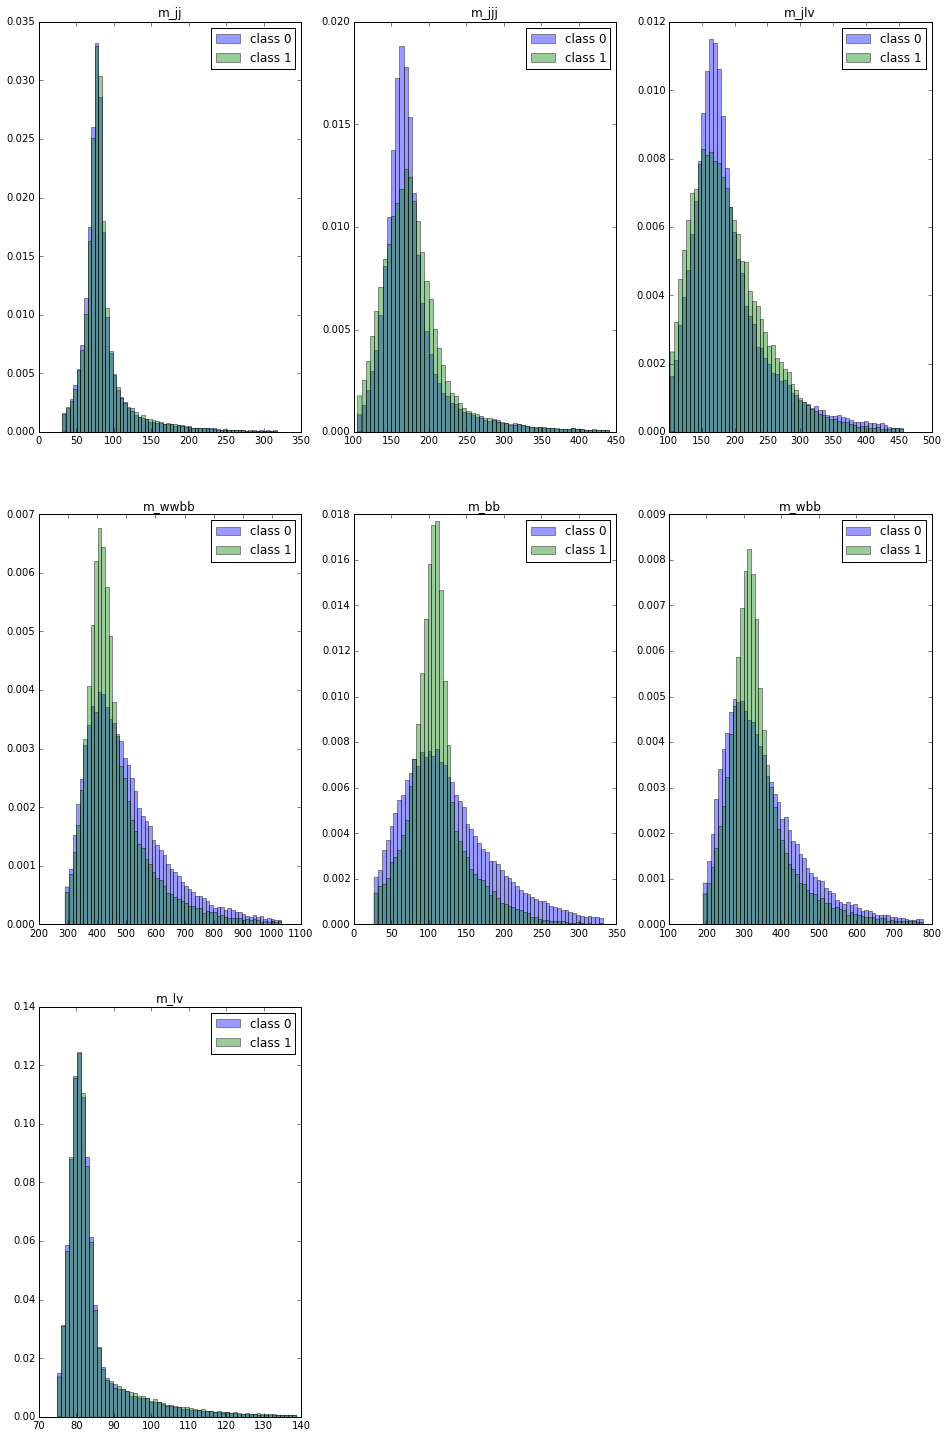

In [40]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(high_level_features):
    # add sub plot on our figure
    plt.subplot(len(high_level_features) // 3 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    #plt.legend()
    plt.title(feature)

## Jet Features

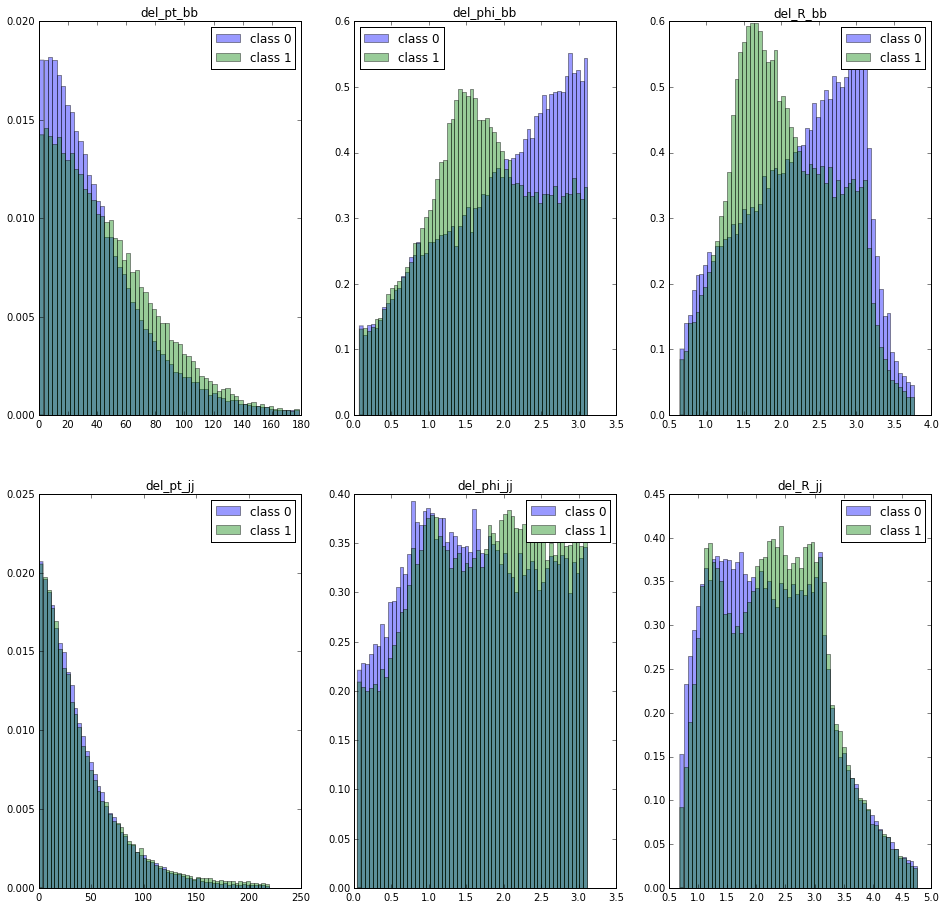

In [41]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}

jet_features = ['del_pt_bb', 'del_phi_bb', 'del_R_bb', 'del_pt_jj', 'del_phi_jj', 'del_R_jj']

# create the figure
plt.figure(figsize=(16, 24))
for n, feature in enumerate(jet_features):
    # add sub plot on our figure
    plt.subplot(len(jet_features) // 3 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    #plt.legend()
    plt.title(feature)

## Distance Features

['del_R_lb', 'del_R_lj', 'del_R_bj', 'del_phi_lmem', 'del_phi_lj']


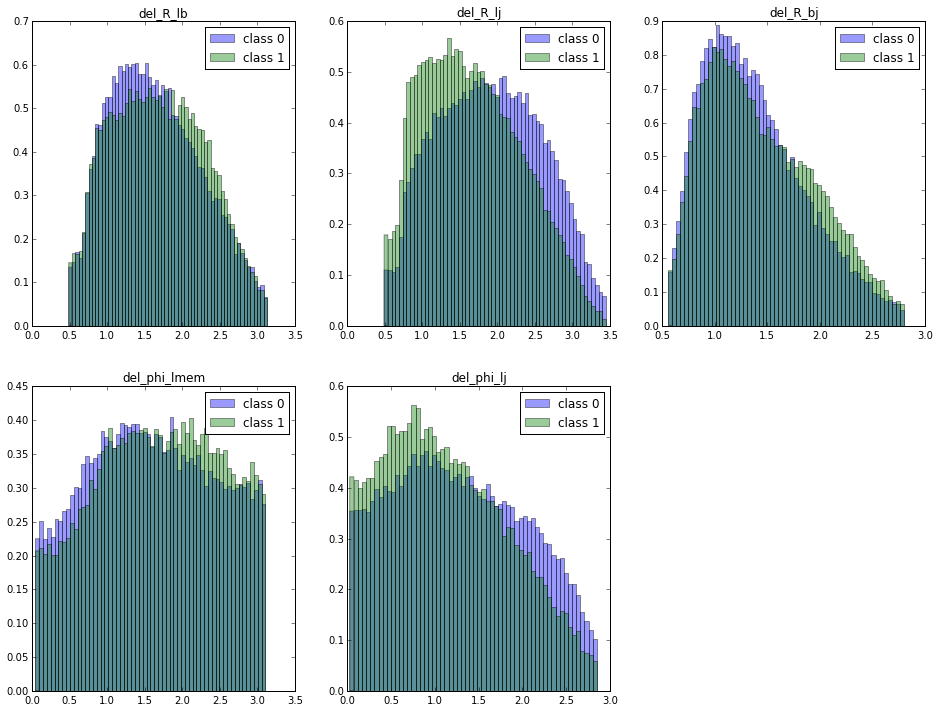

In [42]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}

print distance_features

# create the figure
plt.figure(figsize=(16, 12))
for n, feature in enumerate(distance_features):
    # add sub plot on our figure
    plt.subplot(len(distance_features) // 3 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    #plt.legend()
    plt.title(feature)

## Pt Pair Features

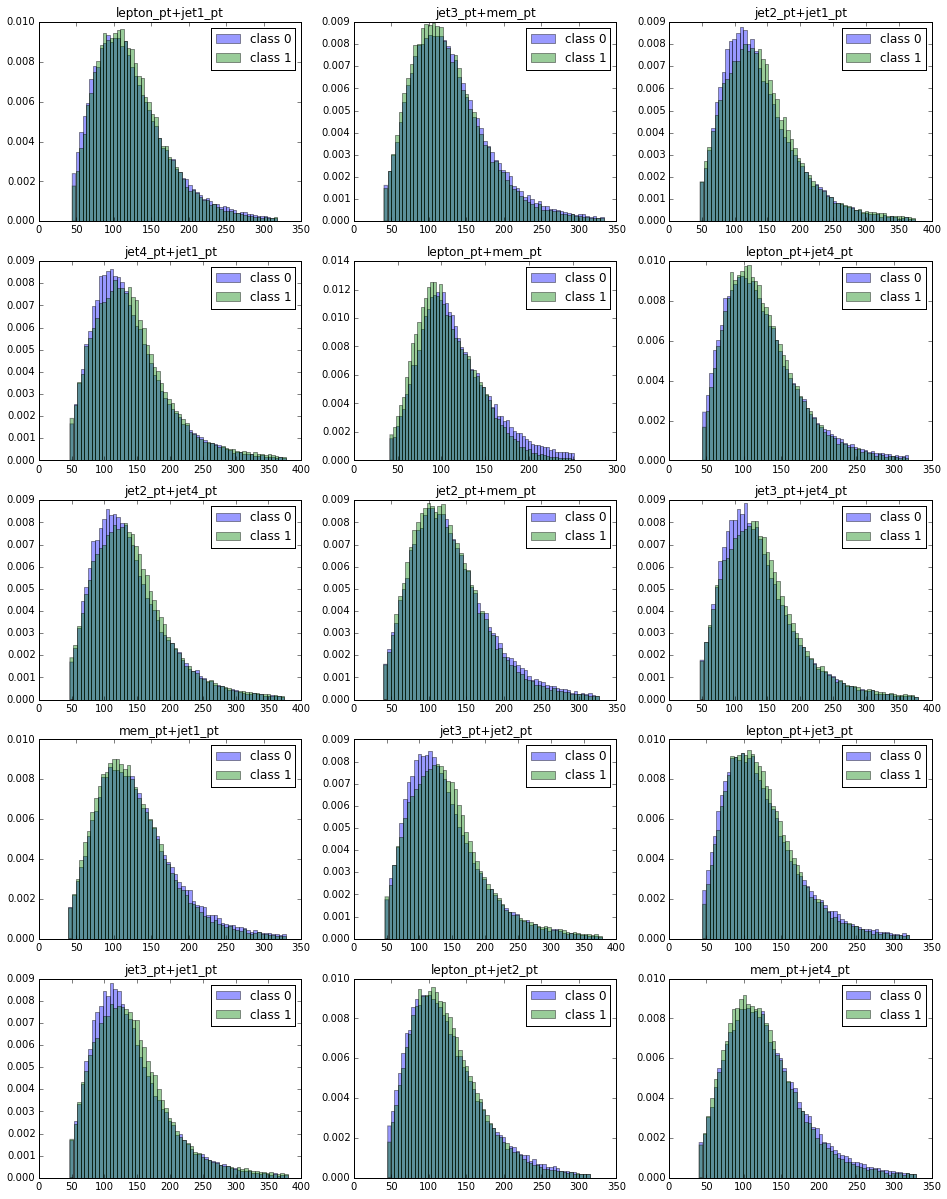

In [43]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}

# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(pt_pair_features):
    # add sub plot on our figure
    plt.subplot(len(pt_pair_features) // 3 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    #plt.legend()
    plt.title(feature)

## Provided Low-Level Features

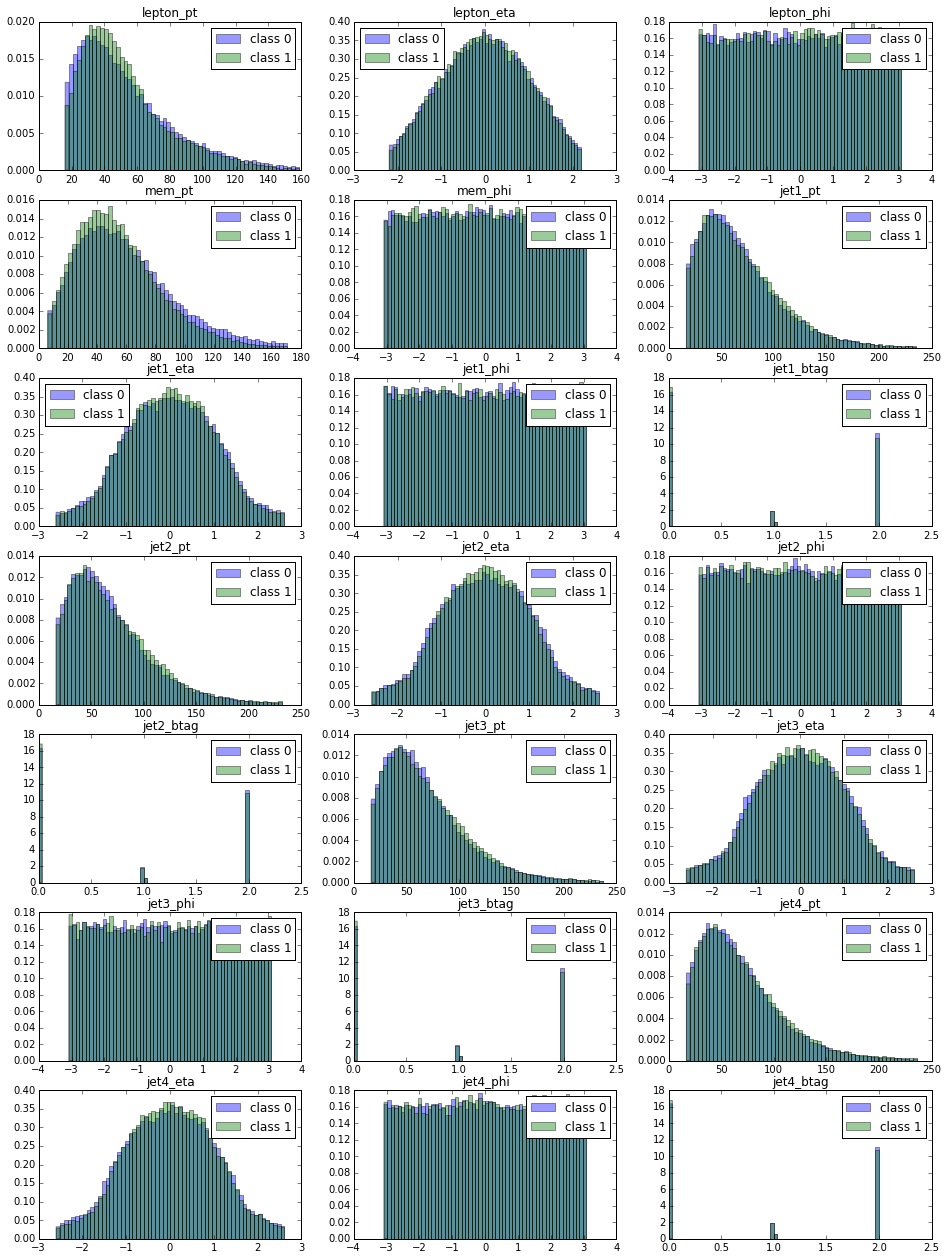

In [47]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(low_level_features):
    # add sub plot on our figure
    plt.subplot(len(low_level_features) // 3 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    #plt.legend()
    plt.title(feature)

## Classifiers

### knn

In [49]:
from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors=6)
knn = KNeighborsClassifier(n_neighbors=10)
#knn.fit(training_data[training_features], training_data.target)

### AdaBoost of XGBoostClassifier

In [74]:
from rep.estimators import XGBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

In [75]:
feature_sets = []
feature_sets.append(provided_features)
feature_sets.append(frozenset(['sum_pt']))
feature_sets.append(jet_features)
feature_sets.append(distance_features)
feature_sets.append(pt_pair_features)

for feature_set in feature_sets:
    print feature_set

['lepton_pt', 'lepton_eta', 'lepton_phi', 'mem_pt', 'mem_phi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag', 'm_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
frozenset(['sum_pt'])
['del_pt_bb', 'del_phi_bb', 'del_R_bb', 'del_pt_jj', 'del_phi_jj', 'del_R_jj']
['del_R_lb', 'del_R_lj', 'del_R_bj', 'del_phi_lmem', 'del_phi_lj']
['lepton_pt+jet1_pt', 'jet3_pt+mem_pt', 'jet2_pt+jet1_pt', 'jet4_pt+jet1_pt', 'lepton_pt+mem_pt', 'lepton_pt+jet4_pt', 'jet2_pt+jet4_pt', 'jet2_pt+mem_pt', 'jet3_pt+jet4_pt', 'mem_pt+jet1_pt', 'jet3_pt+jet2_pt', 'lepton_pt+jet3_pt', 'jet3_pt+jet1_pt', 'lepton_pt+jet2_pt', 'mem_pt+jet4_pt']


In [76]:
ada_xgb_features = provided_features + ['sum_pt'] + jet_features + distance_features + pt_pair_features
print ada_xgb_features

['lepton_pt', 'lepton_eta', 'lepton_phi', 'mem_pt', 'mem_phi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_btag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_btag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_btag', 'jet4_pt', 'jet4_eta', 'jet4_phi', 'jet4_btag', 'm_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv', 'sum_pt', 'del_pt_bb', 'del_phi_bb', 'del_R_bb', 'del_pt_jj', 'del_phi_jj', 'del_R_jj', 'del_R_lb', 'del_R_lj', 'del_R_bj', 'del_phi_lmem', 'del_phi_lj', 'lepton_pt+jet1_pt', 'jet3_pt+mem_pt', 'jet2_pt+jet1_pt', 'jet4_pt+jet1_pt', 'lepton_pt+mem_pt', 'lepton_pt+jet4_pt', 'jet2_pt+jet4_pt', 'jet2_pt+mem_pt', 'jet3_pt+jet4_pt', 'mem_pt+jet1_pt', 'jet3_pt+jet2_pt', 'lepton_pt+jet3_pt', 'jet3_pt+jet1_pt', 'lepton_pt+jet2_pt', 'mem_pt+jet4_pt']


In [60]:
start = time()

ada_on_xgb = cross_val_score(AdaBoostClassifier(base_estimator=XGBoostClassifier()),
                              data[ada_xgb_features], data.target, cv=4, scoring="roc_auc")

end = time()
print 'time spent: ', float(end-start)
print(ada_on_xgb.mean(), ada_on_xgb.std())

time spent:  2798.47081184
(0.80418695220073544, 0.0021525662736874345)


In [77]:
start = time()

model = AdaBoostClassifier(base_estimator=XGBoostClassifier())
model.fit(data[ada_xgb_features], data.target)

end = time()
print 'time spent: ', float(end-start)

time spent:  77.5745840073


## Prepare test sample: constructed high level features

In [79]:
test['sum_pt'] = test['lepton_pt']+test['mem_pt']+test['jet1_pt']+test['jet2_pt']+test['jet3_pt']+test['jet4_pt']

In [80]:
%%time
from itertools import product
pt_pairs = frozenset(filter(lambda pair:len(pair) == 2, map(frozenset, product(pt_features, pt_features))))
print pt_pairs
test_pair_features = []
pair_names = []
for pt_pair in pt_pairs:
    m1, m2 = pt_pair
    test_pair_features.append(test[m1] + test[m2])
    pair_names.append("%s+%s" % (m1, m2))
test_pair_features = pandas.concat( test_pair_features, axis=1)
pandas.options.display.max_columns = 60
#pt_pair_features
test_pair_features.columns = pair_names
#test_pair_features
test[pair_names] = test_pair_features
pt_pair_features = pair_names
print pt_pair_features

frozenset([frozenset(['lepton_pt', 'jet1_pt']), frozenset(['jet3_pt', 'mem_pt']), frozenset(['jet2_pt', 'jet1_pt']), frozenset(['jet4_pt', 'jet1_pt']), frozenset(['lepton_pt', 'mem_pt']), frozenset(['lepton_pt', 'jet4_pt']), frozenset(['jet2_pt', 'jet4_pt']), frozenset(['jet2_pt', 'mem_pt']), frozenset(['jet3_pt', 'jet4_pt']), frozenset(['mem_pt', 'jet1_pt']), frozenset(['jet3_pt', 'jet2_pt']), frozenset(['lepton_pt', 'jet3_pt']), frozenset(['jet3_pt', 'jet1_pt']), frozenset(['lepton_pt', 'jet2_pt']), frozenset(['mem_pt', 'jet4_pt'])])
['lepton_pt+jet1_pt', 'jet3_pt+mem_pt', 'jet2_pt+jet1_pt', 'jet4_pt+jet1_pt', 'lepton_pt+mem_pt', 'lepton_pt+jet4_pt', 'jet2_pt+jet4_pt', 'jet2_pt+mem_pt', 'jet3_pt+jet4_pt', 'mem_pt+jet1_pt', 'jet3_pt+jet2_pt', 'lepton_pt+jet3_pt', 'jet3_pt+jet1_pt', 'lepton_pt+jet2_pt', 'mem_pt+jet4_pt']
CPU times: user 79.2 ms, sys: 16 ms, total: 95.2 ms
Wall time: 89.3 ms


In [82]:
del_pts_bb_test = []
del_phis_bb_test = []
del_Rs_bb_test = []

del_pts_jj_test = []
del_phis_jj_test = []
del_Rs_jj_test = []

del_Rs_lb_test = []
del_Rs_lj_test = []
del_Rs_bj_test = []
del_phis_lmem_test = []
del_phis_lj_test   = []

for index, row in test[btag_features].iterrows():
    np_row   = numpy.reshape(numpy.array(row),(len(btag_features),1))
    stack = list(numpy.reshape(numpy.hstack((np_row,jet_index)),(4,2)))
    stack_sorted = sorted(stack,key=getKey,reverse=True)[:]
    
    #Getting bjets
    b1_index = int(stack_sorted[0][1])
    b2_index = int(stack_sorted[1][1])
    b1_label = 'jet{}_'.format(b1_index)
    b2_label = 'jet{}_'.format(b2_index)
    b1_pt = test.iloc[index]['{}pt'.format(b1_label)]
    b2_pt = test.iloc[index]['{}pt'.format(b2_label)]
    b1_eta = test.iloc[index]['{}eta'.format(b1_label)]
    b2_eta = test.iloc[index]['{}eta'.format(b2_label)]
    b1_phi = test.iloc[index]['{}phi'.format(b1_label)]
    b2_phi = test.iloc[index]['{}phi'.format(b2_label)]
    
    #Getting not-so-btagged jets
    j1_index = int(stack_sorted[2][1])
    j2_index = int(stack_sorted[3][1])
    j1_label = 'jet{}_'.format(j1_index)
    j2_label = 'jet{}_'.format(j2_index)
    j1_pt = test.iloc[index]['{}pt'.format(j1_label)]
    j2_pt = test.iloc[index]['{}pt'.format(j2_label)]
    j1_eta = test.iloc[index]['{}eta'.format(j1_label)]
    j2_eta = test.iloc[index]['{}eta'.format(j2_label)]
    j1_phi = test.iloc[index]['{}phi'.format(j1_label)]
    j2_phi = test.iloc[index]['{}phi'.format(j2_label)]
    
    lepton_pt = test.iloc[index]['lepton_pt']
    lepton_eta = test.iloc[index]['lepton_eta']
    lepton_phi = test.iloc[index]['lepton_phi']
    
    mem_pt = test.iloc[index]['mem_pt']
    mem_phi = test.iloc[index]['mem_phi']
    
    del_R_lb = numpy.min([delta_R(lepton_eta,b1_eta,lepton_phi,b1_phi),
                          delta_R(lepton_eta,b2_eta,lepton_phi,b2_phi)])
    del_R_lj = numpy.min([delta_R(lepton_eta,j1_eta,lepton_phi,j1_phi),
                          delta_R(lepton_eta,j2_eta,lepton_phi,j2_phi)])
    del_R_bj = numpy.min([delta_R(b1_eta,j1_eta,b1_phi,j1_phi),
                          delta_R(b1_eta,j2_eta,b1_phi,j2_phi),
                          delta_R(b2_eta,j1_eta,b2_phi,j1_phi),
                          delta_R(b2_eta,j2_eta,b2_phi,j2_phi)])
    del_phi_lmem = delta_phi(lepton_phi,mem_phi)
    del_phi_lj   = numpy.min([delta_phi(lepton_phi,j1_phi),
                              delta_phi(lepton_phi,j2_phi)])
    
    del_pt_bb  = numpy.abs(b1_pt  - b2_pt)
    del_phi_bb = delta_phi(b1_phi, b2_phi)
    del_R_bb   = delta_R(b1_eta,b2_eta,b1_phi,b2_phi)
    del_pts_bb_test.append(del_pt_bb)
    del_phis_bb_test.append(del_phi_bb)
    del_Rs_bb_test.append(del_R_bb)
    
    del_pt_jj  = numpy.abs(j1_pt  - j2_pt)
    del_phi_jj = delta_phi(j1_phi, j2_phi)
    del_R_jj   = delta_R(j1_eta,j2_eta,j1_phi,j2_phi)
    del_pts_jj_test.append(del_pt_jj)
    del_phis_jj_test.append(del_phi_jj)
    del_Rs_jj_test.append(del_R_jj)
    
    del_Rs_lb_test.append(del_R_lb)
    del_Rs_lj_test.append(del_R_lj)
    del_Rs_bj_test.append(del_R_bj)
    del_phis_lmem_test.append(del_phi_lmem)
    del_phis_lj_test.append(del_phi_lj)


#print np.array(del_pts_bb).shape
test['del_pt_bb']=numpy.array(del_pts_bb_test)
test['del_phi_bb']=numpy.array(del_phis_bb_test)
test['del_R_bb']=numpy.array(del_Rs_bb_test)

test['del_pt_jj']=numpy.array(del_pts_jj_test)
test['del_phi_jj']=numpy.array(del_phis_jj_test)
test['del_R_jj']=numpy.array(del_Rs_jj_test)

test['del_R_lb']=numpy.array(del_Rs_lb_test)
test['del_R_lj']=numpy.array(del_Rs_lj_test)
test['del_R_bj']=numpy.array(del_Rs_bj_test)
test['del_phi_lmem']=numpy.array(del_phis_lmem_test)
test['del_phi_lj']=numpy.array(del_phis_lj_test)

In [83]:
test_all_copy = test.copy()
print test.shape
test.head()

(1000000, 56)


,event_id,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,jet2_pt,jet2_eta,jet2_phi,jet2_btag,jet3_pt,jet3_eta,jet3_phi,jet3_btag,jet4_pt,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,sum_pt,lepton_pt+jet1_pt,jet3_pt+mem_pt,jet2_pt+jet1_pt,jet4_pt+jet1_pt,lepton_pt+mem_pt,lepton_pt+jet4_pt,jet2_pt+jet4_pt,jet2_pt+mem_pt,jet3_pt+jet4_pt,mem_pt+jet1_pt,jet3_pt+jet2_pt,lepton_pt+jet3_pt,jet3_pt+jet1_pt,lepton_pt+jet2_pt,mem_pt+jet4_pt,del_pt_bb,del_phi_bb,del_R_bb,del_pt_jj,del_phi_jj,del_R_jj,del_R_lb,del_R_lj,del_R_bj,del_phi_lmem,del_phi_lj
0,1,58.814354,-1.223199,1.290717,26.435696,2.608772,68.413330,0.639561,-1.226549,1.000008,28.192644,1.319475,2.704676,0.000000,90.252411,-0.443325,-0.734594,1.999937,35.200653,-1.195189,1.767687,0.000000,72.190338,170.810608,78.644196,224.813538,95.737434,372.835388,469.654236,307.309082,127.227684,116.688110,96.605972,103.613983,85.250046,94.015007,63.393295,54.628342,125.453064,94.849030,118.445053,149.066772,158.665741,87.006996,61.636349,21.839081,0.491954,1.189396,7.008009,0.936989,2.683559,2.170275,0.477792,2.448265,1.318054,0.476970
1,2,21.390781,-0.468277,-1.371404,57.185963,1.214130,118.127953,-0.113784,-2.182008,0.000000,107.238831,-1.082186,0.232456,2.000016,68.670891,0.110876,2.863325,0.000000,40.473949,0.965376,2.698023,1.000000,62.736309,215.426300,73.971413,211.729141,195.910385,310.480103,431.597137,413.088379,139.518738,125.856857,225.366791,158.601898,78.576744,61.864731,147.712784,164.424789,109.144836,175.313919,175.909729,90.061676,186.798843,128.629608,97.659912,66.764877,2.465567,3.204923,49.457062,1.237852,1.258074,1.717339,0.884728,0.870341,2.585535,0.810604
2,3,58.570217,1.443092,0.105191,54.450954,-2.354347,26.443583,-1.911658,1.337635,0.000000,154.289459,-1.142575,-2.166013,0.999969,139.899277,0.307173,1.089414,2.000016,24.017288,-2.212247,-2.609508,0.000000,48.172768,163.506821,106.111038,260.643646,351.328644,638.053040,790.960815,457.670776,85.013802,194.350235,180.733047,50.460869,113.021172,82.587509,178.306747,208.740417,163.916565,80.894539,294.188721,198.469498,166.342865,212.859680,78.468246,14.390182,3.027759,3.356947,2.426294,2.336043,2.355303,1.502999,3.573970,1.157967,2.459538,1.232444
3,4,70.469345,0.166176,-1.962429,38.138966,2.564890,42.678413,-1.256608,-0.276156,2.000000,42.376274,0.249604,-0.689569,0.000000,61.597656,-0.904709,1.914711,0.000000,37.422001,-0.007441,3.048725,2.000023,99.099815,158.532227,79.701500,169.550491,96.056900,305.073212,402.656067,292.682648,113.147758,99.736618,85.054688,80.100418,108.608307,107.891342,79.798279,80.515244,99.019653,80.817383,103.973930,132.067001,104.276070,112.845619,75.560966,5.256413,2.958305,3.211228,19.221382,2.604281,2.848634,1.283825,1.275591,1.446055,1.755866,1.272860
4,5,113.456779,0.232503,2.941150,64.401146,1.125812,164.289139,-0.735258,-0.590741,1.999937,48.857182,-0.814078,3.020974,0.000000,32.992023,-0.362528,-2.159055,0.000000,37.717247,-0.943712,1.599526,2.000023,50.816051,200.099945,130.013855,187.637009,142.145920,433.032440,507.496399,461.713531,277.745911,97.393173,213.146317,202.006378,177.857925,151.174026,86.574432,113.258331,70.709274,228.690277,81.849205,146.448807,197.281158,162.313965,102.118393,126.571892,2.190267,2.200164,15.865158,1.103155,1.191994,1.784219,1.049621,1.427347,1.815339,0.079824


## Prepare submission to kaggle

In [84]:
# predict test sample
kaggle_proba = model.predict_proba(test[ada_xgb_features])[:, 1]
kaggle_ids = test.event_id

In [85]:
from IPython.display import FileLink
def create_solution(kaggle_ids, kaggle_proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': kaggle_ids, 'prediction': kaggle_proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)

/notebooks/higgs_kaggle/datasets/baseline.csv